In [109]:
from collections.abc import Sequence
import math

import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import rotate
from scipy.spatial.transform import Rotation
import vedo

from histalign.backend.ccf.paths import get_atlas_path
from histalign.backend.io import load_volume
from histalign.backend.models import (
    Orientation,
    Resolution,
)
from histalign.backend.models.errors import InvalidOrientationError

vedo.settings.default_backend = "vtk"

In [110]:
def imshow(image: np.ndarray) -> None:
    _ = plt.figure()

    plt.imshow(image)
    plt.axis(False)

    plt.show()


def show(meshes: vedo.CommonVisual | list[vedo.CommonVisual]) -> None:
    plotter = vedo.Plotter(axes=4)

    if not isinstance(meshes, list):
        meshes = [meshes]

    for mesh in meshes:
        plotter += mesh

    plotter.show(interactive=False).interactive().close()


def apply_rotation_from_raw(
    vector: np.ndarray, pitch: int, yaw: int, orientation: Orientation
) -> np.ndarray:
    match orientation:
        case Orientation.CORONAL:
            rotation = Rotation.from_euler("ZY", [pitch, yaw], degrees=True)
        case Orientation.HORIZONTAL:
            rotation = Rotation.from_euler("ZX", [pitch, yaw], degrees=True)
        case Orientation.SAGITTAL:
            rotation = Rotation.from_euler("XY", [pitch, yaw], degrees=True)
        case other:
            raise InvalidOrientationError(other)

    return rotation.apply(vector)


def compute_normal_from_raw(
    pitch: int, yaw: int, orientation: Orientation
) -> np.ndarray:
    match orientation:
        case Orientation.CORONAL:
            normal = [1, 0, 0]
        case Orientation.HORIZONTAL:
            normal = [0, 1, 0]
        case Orientation.SAGITTAL:
            normal = [0, 0, 1]
        case other:
            raise InvalidOrientationError(other)

    return apply_rotation_from_raw(np.array(normal), pitch, yaw, orientation).reshape(3)


def compute_centre(shape: Sequence[int]) -> tuple[int, ...]:
    return tuple((np.array(shape) - 1) // 2)


def compute_origin_from_raw(
    centre: Sequence[int], offset: int, orientation: Orientation
) -> np.ndarray:
    if len(centre) != 3:
        raise ValueError(f"Centre should be 3 coordinates. Got {len(centre)}.")

    match orientation:
        case Orientation.CORONAL:
            origin = [centre[0] + offset, centre[1], centre[2]]
        case Orientation.HORIZONTAL:
            origin = [centre[0], centre[1] + offset, centre[2]]
        case Orientation.SAGITTAL:
            origin = [centre[0], centre[1], centre[2] + offset]
        case other:
            raise InvalidOrientationError(other)

    return np.array(origin)


def draw_box(array: np.ndarray) -> np.ndarray:
    box_value = array.max()

    array[0, 0, :] = box_value
    array[0, :, 0] = box_value
    array[:, 0, 0] = box_value

    array[0, -1, :] = box_value
    array[:, 0, -1] = box_value
    array[-1, :, 0] = box_value

    array[-1, 0, :] = box_value
    array[:, -1, 0] = box_value
    array[0, :, -1] = box_value

    array[-1, -1, :] = box_value
    array[-1, :, -1] = box_value
    array[:, -1, -1] = box_value

    return array


# def euclidean_distance(p1, p2):
#     return math.sqrt((p1[0] + p2[0]) ** 2 + (p1[1] + p2[1]) ** 2 + (p1[2] + p2[2]) ** 2)


def magnitude(v):
    return np.sqrt(np.sum(np.array(v) ** 2))


def project_vectors(target, vectors):
    projections = []
    for vector in vectors:
        magnitude_ = magnitude(vector)
        angle = vector_angle(vector, target)
        projections.append(magnitude_ * math.cos(angle))

    return projections


def vector_angle(v1, v2):
    return math.degrees(math.acos(np.dot(v1, v2) / (magnitude(v1) * magnitude(v2))))

In [119]:
shape = (132, 80, 114)
radius = 1
roi = (
    slice(shape[0] // 2 - radius, shape[0] // 2 + radius),
    slice(shape[1] // 2 - radius, shape[1] // 2 + radius),
    slice(shape[2] // 2 - radius, shape[2] // 2 + radius),
)
array = np.zeros(shape, dtype=np.uint8)
array = draw_box(array)
array[roi] = 255

volume = vedo.Volume(array)

atlas = load_volume(get_atlas_path(Resolution.MICRONS_100), return_raw_array=True)
# draw_box(atlas)
atlas = vedo.Volume(atlas)

volume = atlas

orientation = Orientation.CORONAL
offset = 60
pitch = 20
yaw = 30

origin = compute_origin_from_raw(compute_centre(shape), offset, orientation)
normal = compute_normal_from_raw(pitch, yaw, orientation).tolist()

no_crop_plane = volume.slice_plane(
    origin=origin,
    normal=normal,
    autocrop=False,
    border=1.0,
)
no_crop_plane.color("blue")
crop_plane = volume.slice_plane(
    origin=origin,
    normal=normal,
    autocrop=True,
)
crop_plane.color("red")

box = vedo.Box(atlas.bounds())
box.alpha(0.5)
intersection = box.intersect_with_plane(origin, normal=normal)

cropping = no_crop_plane.copy().crop(bounds=atlas.bounds())
cropping.color("cyan")

show(
    [
        box,
        intersection,
        no_crop_plane,
        crop_plane,
        vedo.Point(cropping.center_of_mass(), r=10, c="yellow"),
        vedo.Points(intersection.points, r=10, c="orange"),
    ]
)

In [120]:
plane = volume.slice_plane(
    origin=origin,
    normal=normal,
    autocrop=False,
)

atlas_box = vedo.Box(atlas.bounds())

intersection_points = atlas_box.intersect_with_plane(origin, normal).points

z_normal = compute_normal_from_raw(0, yaw, Orientation.SAGITTAL)
y_normal = np.cross(normal, z_normal)

z_distance = max(np.abs(project_vectors(-z_normal, intersection_points - origin)))
y_distance = max(np.abs(project_vectors(-y_normal, intersection_points - origin)))

# show(
#     [
#         box,
#         atlas_box.intersect_with_plane(origin, normal),
#         # plane,
#         vedo.Points(intersection_points, r=10, c="blue"),
#         # vedo.Arrow(origin, origin - y_distance * y_normal),
#         vedo.Arrow(origin, origin - z_distance * z_normal),
#     ]
# )

In [121]:
plane = vedo.Plane(
    pos=origin, normal=compute_normal_from_raw(0, 0, orientation), s=(150, 150)
)

plane.rotate(pitch, axis=[0, 0, 1], point=origin)
plane.rotate(
    yaw,
    axis=Rotation.from_euler("z", pitch, degrees=True).apply([0, 1, 0]),
    point=origin,
)
plane.rotate(
    -pitch,
    axis=Rotation.from_euler("ZY", [pitch, yaw], degrees=True).apply([1, 0, 0]),
    point=origin,
);


# show(
#     [
#         box,
#         plane,
#         no_crop_plane,
#         # no_crop_plane.copy().crop(bounds=plane.bounds()).color("green"),
#     ]
# )

In [125]:
normal1 = plane.points[0] - plane.points[1]
normal2 = plane.points[1] - plane.points[3]
normal3 = plane.points[3] - plane.points[2]
normal4 = plane.points[2] - plane.points[0]

show(
    [
        box,
        no_crop_plane,
        plane,
        # vedo.Arrow(start_pt=origin, end_pt=origin + normal1),
        # vedo.Plane(pos=origin + normal1 * 0.5, normal=normal1, s=(100, 100)),
        # vedo.Plane(pos=origin + normal2 * 0.5, normal=normal2, s=(100, 100)),
        # vedo.Plane(pos=origin + normal3 * 0.5, normal=normal3, s=(100, 100)),
        # vedo.Plane(pos=origin + normal4 * 0.5, normal=normal4, s=(100, 100)),
        # vedo.Arrow(start_pt=origin, end_pt=normal2),
        # vedo.Arrow(start_pt=origin, end_pt=normal3),
        # vedo.Arrow(start_pt=origin, end_pt=normal4),
    ]
)

In [106]:
def cut_with_plane(plane, origin, normal, height: bool):
    shape = plane.metadata["shape"]

    plane.cut_with_plane(origin=origin, normal=normal, invert=True)

    after = len(plane.points)
    if height:
        after /= shape[1]
    else:
        after /= shape[0]

    if height:
        shape[0] = after
    else:
        shape[1] = after

    plane.metadata["shape"] = shape

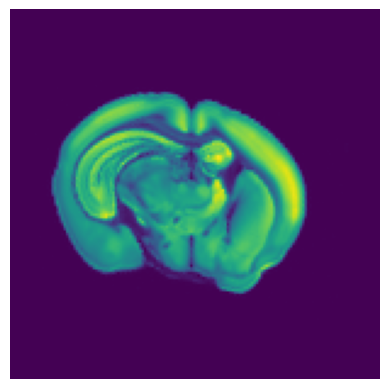

In [108]:
new_plane = no_crop_plane.copy()

cut_with_plane(new_plane, origin + normal1 * 0.5, normal1, height=False)
cut_with_plane(new_plane, origin + normal2 * 0.5, normal2, height=True)
cut_with_plane(new_plane, origin + normal3 * 0.5, normal3, height=False)
cut_with_plane(new_plane, origin + normal4 * 0.5, normal4, height=True)

plane_array = new_plane.pointdata["ImageScalars"].reshape(new_plane.metadata["shape"])

plane_array = rotate(plane_array, pitch, reshape=False)

imshow(plane_array)

In [83]:
new_plane = no_crop_plane.copy()

new_plane.cut_with_plane(origin=origin + normal1 * 0.5, normal=normal1, invert=True)
new_plane.cut_with_plane(origin=origin + normal2 * 0.5, normal=normal2, invert=True)
new_plane.cut_with_plane(origin=origin + normal3 * 0.5, normal=normal3, invert=True)
new_plane.cut_with_plane(origin=origin + normal4 * 0.5, normal=normal4, invert=True)
new_plane.color("green");

# show(
#     [
#         no_crop_plane,
#         plane,
#         new_plane,
#     ]
# )

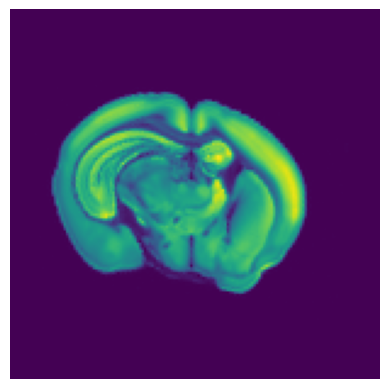

In [18]:
plane_array = new_plane.pointdata["ImageScalars"].reshape(
    # int(euclidean(plane.points[0], plane.points[1])) + 3,
    # int(euclidean(plane.points[0], plane.points[2])) + 2,
    152,
    152,
)

plane_array = rotate(plane_array, pitch, reshape=False)
imshow(plane_array)